In [1]:
from Levenshtein import distance

Product_ID = 'DTEED_024728_1595_024227_1595_A01'
img_path = 'data/DTM/' + Product_ID + '.IMG'
jpg_path = 'data/JPG/' + Product_ID + '.ca.jpg'

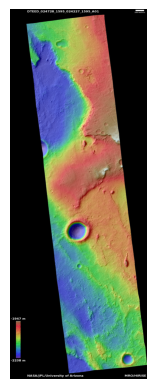

In [2]:
# 显示jpg
from PIL import Image
from matplotlib import pyplot as plt

img = Image.open(jpg_path)
plt.imshow(img)
plt.axis('off')
plt.show()


In [3]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt


dataset = gdal.Open(img_path, gdal.GA_ReadOnly)
# 读取数据
data = dataset.ReadAsArray()
# 获取数据信息
print('Driver: ', dataset.GetDriver().ShortName, '/', dataset.GetDriver().LongName)
print('Size is ', dataset.RasterXSize, 'x', dataset.RasterYSize, 'x', dataset.RasterCount)
print('Projection is ', dataset.GetProjection())
geotransform = dataset.GetGeoTransform()
if not geotransform is None:
    print('Origin = (', geotransform[0], ',', geotransform[3], ')')
    print('Pixel Size = (', geotransform[1], ',', geotransform[5], ')')
# ignore_value
ignore_value = dataset.GetRasterBand(1).GetNoDataValue()
print('ignore_value: ', ignore_value)

Driver:  PDS / NASA Planetary Data System
Size is  3497 x 10431 x 1
Projection is  PROJCS["EQUIRECTANGULAR MARS",GEOGCS["GCS_MARS",DATUM["D_MARS",SPHEROID["MARS_localRadius",3393833.2607584,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Equirectangular"],PARAMETER["standard_parallel_1",-20],PARAMETER["central_meridian",329.99],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Origin = ( -3537.394372595001 , -1204253.7512038578 )
Pixel Size = ( 2.0179089404421 , -2.0179089404421 )
ignore_value:  -3.4028226550889045e+38


In [4]:
# ignore_value用NAN替代
data[data == ignore_value] = np.NAN

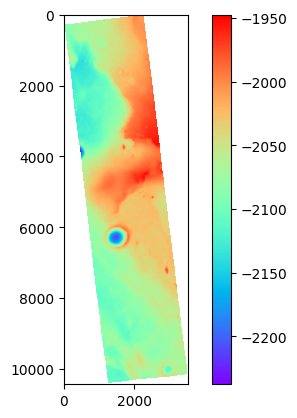

In [5]:
# data画图,带色条
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.imshow(data, cmap='rainbow')
plt.colorbar()
plt.show()

In [6]:
# 划分方格
data_mask = np.isnan(data)
center = [int(data_mask.shape[0] / 2), int(data_mask.shape[1] / 2)]

In [7]:
# 取出最大区域全为true的区域
count = 1
while True:
    if np.all(data_mask[center[0] - count: center[0] + count+1, center[1] - count: center[1] + count+1] == False):
        count += 1
    else:
        count -= 1
        break
print(count)

1013


In [8]:
data_cut = data[center[0] - count: center[0] + count+1, center[1] - count: center[1] + count+1]

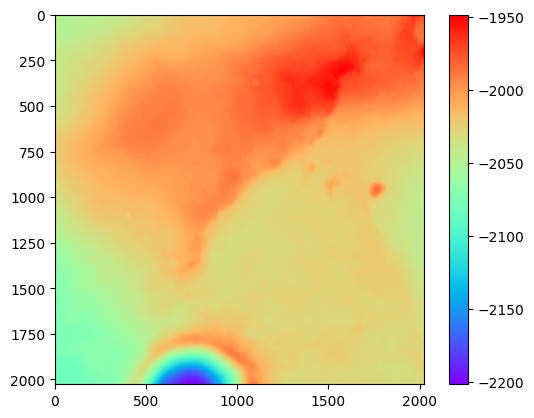

In [9]:

plt.imshow(data_cut, cmap='rainbow')
plt.colorbar()

In [10]:
geotransform = dataset.GetGeoTransform()
if abs(geotransform[1]) != abs(geotransform[5]):
    print('warning: 两个方向上的距离间隔不一致')
map_scale = abs(geotransform[1])
actural_interval = 100  # m
interval = int(actural_interval / map_scale)
if interval % 2 == 0:
        interval = interval + 1

In [11]:
from scipy.signal import convolve
def filter_1d(dem,_interval):
    filter_dem = np.pad(dem, (_interval, _interval), 'edge')
    # 对间隔interval的数据进行拟合，得到大范围的data的趋势
    _filter_kernel = np.ones(_interval) / _interval
    # 应用滤波器,边界填充方式为镜像填充
    big_scale_dem = convolve(filter_dem, _filter_kernel, mode='same', method='auto')
    big_scale_dem = big_scale_dem[interval:-interval]
    small_scale_dem = dem - big_scale_dem
    return big_scale_dem,small_scale_dem

In [12]:
from numpy.fft import fft,ifft,fftshift,ifftshift
def filter_1d_fft(dem,_interval):
    filter_dem = np.pad(dem, (_interval, _interval), 'edge')
    _filter_kernel = np.ones(_interval) / _interval
    _filter_pad_size = int((filter_dem.shape[0] - _interval)/2)
    _filter_kernel = np.pad(_filter_kernel, (_filter_pad_size, _filter_pad_size), 'constant')
    
    filter_dem_fft = fft(filter_dem)
    filter_kernel_fft = fft(_filter_kernel)
    
    filtered_result = filter_dem_fft * filter_kernel_fft
    
    filtered_result = fftshift(ifft(filtered_result)).real
    
    big_scale_dem = filtered_result[interval:-interval]
    small_scale_dem = dem - big_scale_dem
    return big_scale_dem,small_scale_dem

In [16]:
bs_1d,ss_1d = filter_1d_fft(data_cut[0,:],interval)

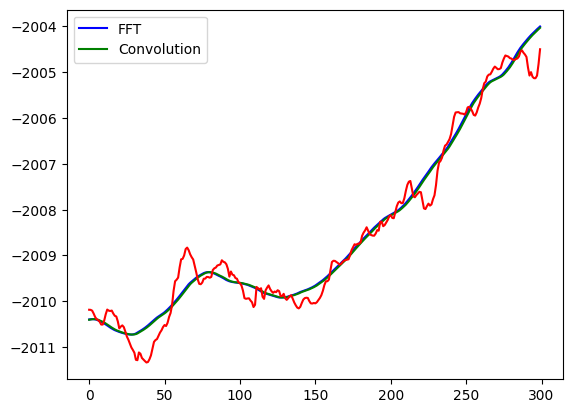

In [25]:
bs_1d_1,ss_1d_1 = filter_1d(data_cut[0,:],interval)
plt.plot(bs_1d[1000:1300],'b',label='FFT')
plt.plot(bs_1d_1[1000:1300],'g',label='Convolution')
plt.plot(data_cut[0,1000:1300],'r')
plt.legend()

(-2.0, 2.0)

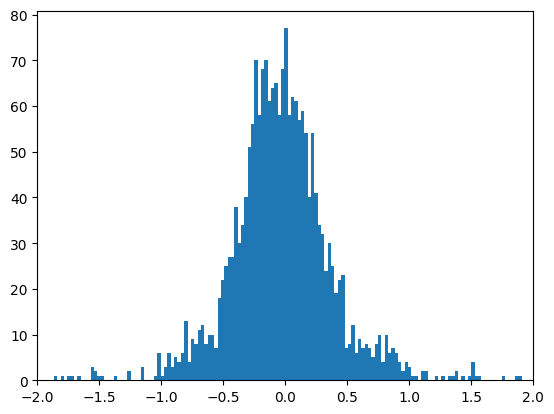

In [16]:

plt.hist(ss_1d,bins=150)
plt.xlim(-2,2)

In [17]:
from scipy.signal import convolve2d

def filter_2d(dem,_interval):
    _filter_kernel = np.ones((interval, interval)) / (interval **2) 
    big_scale_dem = convolve2d(dem, _filter_kernel, mode='same', boundary='symm')
    small_scale_dem = dem - big_scale_dem
    return big_scale_dem,small_scale_dem

In [18]:
from numpy.fft import fft2,ifft2
def filter_2d_fft(dem, _interval):
    # 对数据进行零填充，以便与滤波器核进行卷积
    padded_dem = np.pad(dem, ((_interval, _interval), (_interval, _interval)), 'edge')
    
    # 生成滤波器核，并对其进行零填充以匹配输入数据的尺寸
    _filter_kernel = np.ones((_interval, _interval)) / (_interval ** 2)
    _filter_pad_size = int((padded_dem.shape[0]-_interval)/2)
    padded_kernel = np.pad(_filter_kernel, ((_filter_pad_size, _filter_pad_size), (_filter_pad_size, _filter_pad_size)), 'constant')
    
    # 计算输入数据和滤波器核的二维傅里叶变换
    dem_fft = fft2(padded_dem)
    kernel_fft = fft2(padded_kernel)
    
    # 频域相乘
    result_fft = dem_fft * kernel_fft
    
    # 逆二维傅里叶变换回到空间域
    filtered_result = fftshift(ifft2(result_fft)).real
    
    # 截取有效部分
    big_scale_dem = filtered_result[_interval:-_interval, _interval:-_interval]
    
    # 计算小尺度细节
    small_scale_dem = dem - big_scale_dem
    
    return big_scale_dem, small_scale_dem

In [19]:
bs_2d,ss_2d = filter_2d_fft(data_cut,interval)

In [20]:

plt.imshow(ss_2d,cmap='rainbow')
plt.colorbar()

<IPython.core.display.Javascript object>

In [21]:
#对比x轴第一条的bs_2d和ss_2d，和y轴第一条的bs_2d和ss_2d

plt.plot(bs_2d[0,:500],'b')
plt.plot(data_cut[0,:500],'r')

<IPython.core.display.Javascript object>

In [22]:

plt.hist(ss_2d.flatten(),bins=1000)
plt.xlim(-2,2)

<IPython.core.display.Javascript object>

(-2.0, 2.0)

In [23]:
def RMSH(dem):
    dem_mean = np.nanmean(dem)
    rmsh = np.sqrt(np.nansum((dem - dem_mean) ** 2) / (np.sum(~np.isnan(dem)) - 1))
    return rmsh

In [24]:
rmsh_1d = np.zeros(data_cut.shape[0])
for i in range(data_cut.shape[0]):
    bs_1d,ss_1d = filter_1d(data_cut[i,:],interval)
    rmsh_1d[i] = RMSH(ss_1d)
rmsh_2d = RMSH(ss_2d)
print(np.mean(rmsh_1d),rmsh_2d)

0.49776207899321545 0.7336527329504622


In [48]:
autocorrelation_1d = np.ones((data_cut.shape[0],ss_2d.shape[0]-1))
for i in range(data_cut.shape[0]):
    bs_1d,ss_1d = filter_1d_fft(data_cut[i,:],interval)
    mean_1d = np.mean(ss_1d)
    temp1 = np.sum((ss_1d-mean_1d) ** 2)
    centered_ss_1d = ss_1d - mean_1d
    for j in range(0,ss_1d.shape[0]-1):
        autocorrelation_1d[i][j] = np.sum(centered_ss_1d[0:ss_1d.shape[0]-j] * centered_ss_1d[j:ss_1d.shape[0]])/temp1

In [56]:
autocorrelation_1d_fast = np.ones((data_cut.shape[0],data_cut.shape[1]-1))
ss_1d_all = np.zeros((data_cut.shape[0],data_cut.shape[1]))
for i in range(data_cut.shape[0]):
    ss_1d_all[i,:] = filter_1d_fft(data_cut[i,:],interval)[1]
mean_1d = np.mean(ss_1d_all,axis=1)
centered_ss_1d_all = (ss_1d_all.T-mean_1d).T
temp1 = np.sum(centered_ss_1d_all ** 2,axis=1)
for j in range(0,ss_1d.shape[0]-1):
        autocorrelation_1d_fast[:,j] = np.sum(centered_ss_1d_all[:,0:ss_1d.shape[0]-j] * centered_ss_1d_all[:,j:ss_1d.shape[0]],axis=1)/temp1

In [83]:
from numpy.fft import fft, ifft, fftshift
def autocorrelation_1d(_dem):
    _mean_1d = np.mean(_dem)
    _Var_1d_1 = np.sum((_dem-_mean_1d) ** 2)
    _pad_size = int(_dem.shape[0] / 2)
    _expanded_ss_1d = np.pad(_dem - _mean_1d, _pad_size, 'constant')
    _fft_1d = fft(_expanded_ss_1d)
    _fft_1d_conj = np.conj(_fft_1d)
    _F_prod = _fft_1d * _fft_1d_conj
    _rho_num = fftshift(ifft(_F_prod)).real
    _autocorrelation_1d = _rho_num[_pad_size:-_pad_size]/_Var_1d_1
    return _autocorrelation_1d[_pad_size:]
autocorrelation_1d_fft = np.zeros((data_cut.shape[0],int(data_cut.shape[1]/2)+1))
for i in range(data_cut.shape[0]):
    autocorrelation_1d_fft[i,:] = autocorrelation_1d(_dem=filter_1d_fft(data_cut[i,:],interval)[1])

In [84]:
autocorrelation_1d_max = np.max(autocorrelation_1d_fft,axis=0)
autocorrelation_1d_min = np.min(autocorrelation_1d_fft,axis=0)
autocorrelation_1d_mean = np.mean(autocorrelation_1d_fft,axis=0)

plt.plot(autocorrelation_1d_max[:500],'b')
plt.plot(autocorrelation_1d_min[:500],'r')
plt.plot(autocorrelation_1d_mean[:500],'g')

<IPython.core.display.Javascript object>

In [157]:
autocorrelation_1d_max = np.max(autocorrelation_1d,axis=0)
autocorrelation_1d_min = np.min(autocorrelation_1d,axis=0)
autocorrelation_1d_mean = np.mean(autocorrelation_1d,axis=0)

In [158]:

plt.plot(autocorrelation_1d_max[:200],'b')
plt.plot(autocorrelation_1d_min[:200],'r')
plt.plot(autocorrelation_1d_mean[:200],'g')

<IPython.core.display.Javascript object>

In [159]:
from numpy.fft import fft2, ifft2, fftshift
def autocorrelation_2d(_dem):
    _mean_2d = np.nanmean(_dem)
    _Var_2d_1 = np.sum((_dem-_mean_2d) ** 2)
    _pad_size = int(_dem.shape[0] / 2)
    _expanded_ss_2d = np.pad(_dem - _mean_2d, (_pad_size, _pad_size), 'constant')
    _fft_2d = fft2(_expanded_ss_2d)
    _fft_2d_conj = np.conj(_fft_2d)
    _F_prod = _fft_2d * _fft_2d_conj
    _rho_num = fftshift(ifft2(_F_prod)).real
    _autocorrelation_2d = _rho_num[_pad_size:-_pad_size, _pad_size:-_pad_size]/_Var_2d_1
    return _autocorrelation_2d

In [160]:
autocorrelation_2d_1 = autocorrelation_2d(ss_2d)

plt.imshow(autocorrelation_2d_1,cmap='rainbow')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>

In [161]:
autocorrelation_2d_2 = autocorrelation_2d(np.flipud(ss_2d))

plt.imshow(autocorrelation_2d_2,cmap='rainbow')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>

In [162]:
np.where(autocorrelation_2d_1 == np.max(autocorrelation_2d_1))

(array([1013], dtype=int64), array([1013], dtype=int64))

In [163]:

plt.plot(autocorrelation_2d_1[1013,400:-400],'b')
plt.plot(autocorrelation_2d_1[400:-400,1013],'r')
plt.show()

<IPython.core.display.Javascript object>

In [164]:

plt.plot(autocorrelation_2d_1[1014,400:-400],'b')
plt.plot(autocorrelation_2d_2[1014,400:-400],'r')
plt.show()

<IPython.core.display.Javascript object>

In [165]:

plt.imshow(autocorrelation_2d_2[900:-900,900:-900],'rainbow')
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>

In [166]:
x = np.arange(data_cut.shape[0])
y = np.arange(data_cut.shape[1])
xx, yy = np.meshgrid(x, y)

In [167]:
data_cut.shape

(2027, 2027)

In [168]:
distance = np.sqrt(((xx - (data_cut.shape[0]-1)/2) * map_scale) ** 2 + ((yy - (data_cut.shape[0]-1)/2) *map_scale) ** 2)

In [169]:

plt.imshow(distance,cmap='rainbow')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>

In [170]:
ac_2d_1_flatten = autocorrelation_2d_1.flatten()
distance_flatten = distance.flatten()
# ac_2d_1_flatten按照distance从小到大排序
ac_2d_1_flatten = ac_2d_1_flatten[distance_flatten.argsort()]
distance_flatten = distance_flatten[distance_flatten.argsort()]

In [171]:

plt.hist(distance_flatten,bins=100)

<IPython.core.display.Javascript object>

(array([  657.,  1928.,  3200.,  4540.,  5816.,  7048.,  8412.,  9676.,
        10936., 12276., 13536., 14800., 16156., 17408., 18656., 20040.,
        21288., 22520., 23852., 25152., 26440., 27748., 28968., 30324.,
        31620., 32824., 34144., 35540., 36720., 38016., 39416., 40616.,
        41848., 43268., 44472., 45760., 47060., 48328., 49692., 50932.,
        52224., 53464., 54844., 56136., 57384., 58504., 60144., 61240.,
        62408., 63900., 65224., 66256., 67812., 68932., 70232., 71612.,
        72856., 74056., 75516., 76768., 77952., 79408., 80576., 81880.,
        83188., 84456., 85736., 87132., 88264., 89604., 89276., 75400.,
        67296., 61760., 57072., 53120., 49676., 46424., 43472., 40664.,
        38088., 35592., 33200., 30840., 28748., 26560., 24456., 22416.,
        20520., 18528., 16648., 14744., 13020., 11168.,  9368.,  7632.,
         6008.,  4248.,  2520.,   924.]),
 array([   0.        ,   28.90852996,   57.81705991,   86.72558987,
         115.63411983,  14

In [172]:

index_dis_below_500 = np.where(distance_flatten < 500)[0]
plt.scatter(distance_flatten[index_dis_below_500],ac_2d_1_flatten[index_dis_below_500])
plt.show()

<IPython.core.display.Javascript object>

In [173]:
crol_2d = autocorrelation_2d_1 - 1/np.e
# 找到corl_2d接近于零+-0.05的点的位置，用scatter函数画出来
index_crol_2d = np.where(np.abs(crol_2d) < 0.01)

plt.imshow(crol_2d,cmap='rainbow')
plt.colorbar()
plt.scatter(index_crol_2d[1], index_crol_2d[0])
plt.xlim(980,1047)
plt.ylim(980,1047)
plt.show()

<IPython.core.display.Javascript object>